# Linear Models

In [1]:
import os
import sys
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from joblib import load
import pandas as pd

In [2]:
sys.path.insert(0, "../..")
import problem

## Load data

In [3]:
X_train, y_train = problem.get_train_data("../..")
X_test, y_test = problem.get_test_data("../..")

## Ridge

### Basic Ridge

In [4]:
date_encoder = FunctionTransformer(problem._encode_dates)
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x7ff0f1ecc5e0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('ridge', Ridge())])

In [5]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.80
Test set, RMSE=0.73


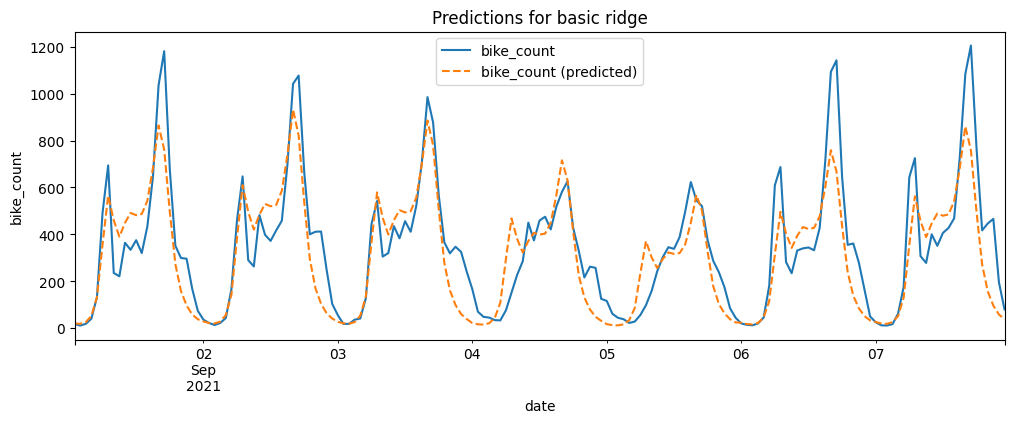

In [6]:
problem.week_plot(X_test, y_pred_test, y_test, "basic ridge")

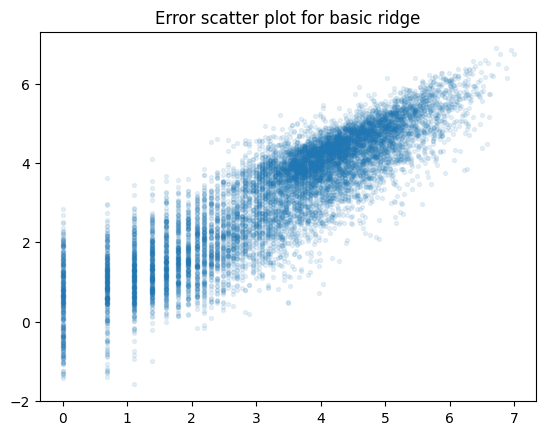

In [7]:
problem.error_plot(y_pred_test, y_test, "basic ridge")

### Ridge including additional data variables

In [8]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.to_list()

add_date_encoder = FunctionTransformer(problem._additional_date_variables)
add_date_cols = ["season"]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols + add_date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, add_date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _encode_dates at 0x7ff0f1ecc5e0>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7ff0f1ecc670>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour',
                                                   'season']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('ridge', Ridge())])

In [9]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.80
Test set, RMSE=0.72


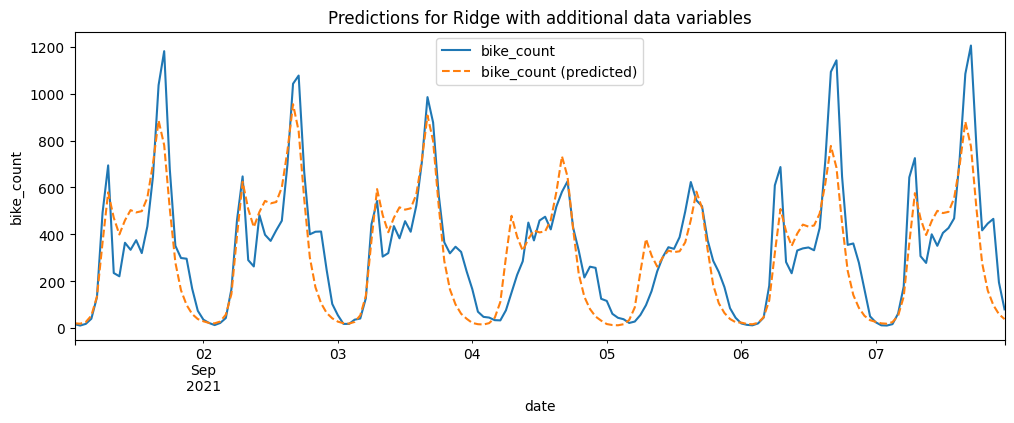

In [10]:
problem.week_plot(X_test, y_pred_test, y_test, "Ridge with additional data variables")

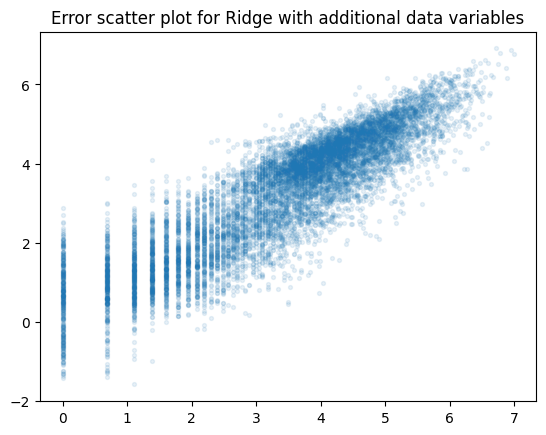

In [11]:
problem.error_plot(y_pred_test, y_test, "Ridge with additional data variables")

### Ridge including aditional variables and weather data

In [12]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(problem._additional_date_variables)
add_date_cols = ["season"]

num_cols = ["temp", "dwpt", "rhum", "prcp", "wspd", "pres"]

categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols + add_date_cols),
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
)

regressor = Ridge()

pipe = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor,
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7ff0f1ecc700>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7ff0f1ecc5e0>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7ff0f1ecc670>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour',
                                                   'season']),
                                                 ('num', StandardScaler(),
                                                  ['temp', 'dwpt', 'rhum',
                                                   'prcp', 'wspd', 'pres']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wdir'])])),
                ('ridge', Ridge())])

In [13]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.79
Test set, RMSE=0.72


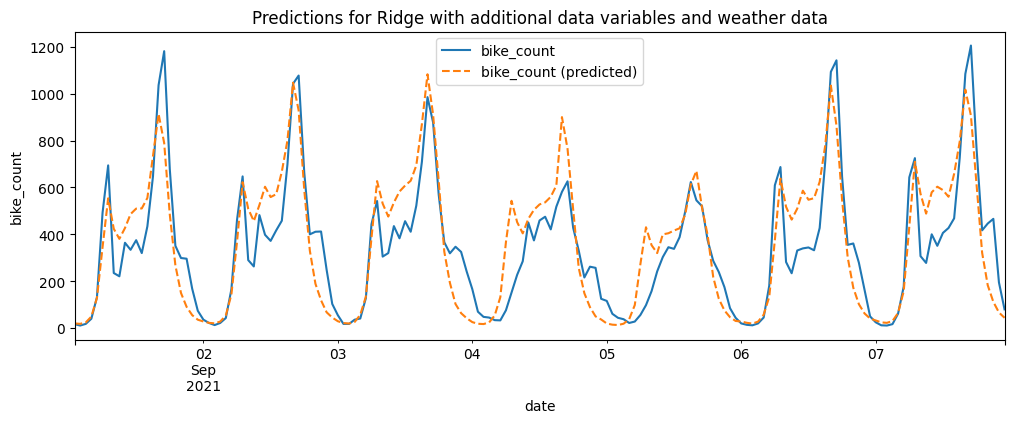

In [14]:
problem.week_plot(
    X_test, y_pred_test, y_test, "Ridge with additional data variables and weather data"
)

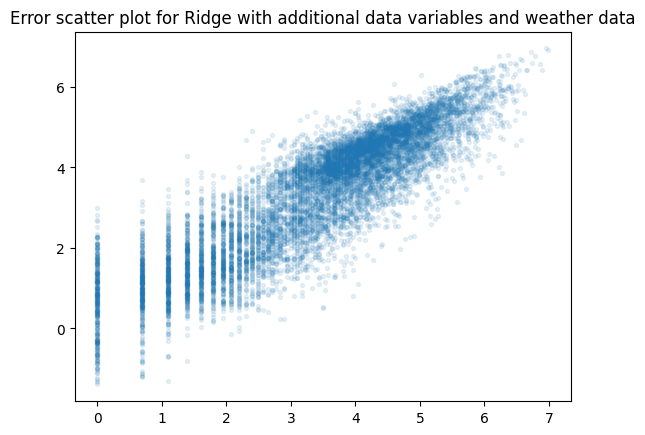

In [15]:
problem.error_plot(
    y_pred_test, y_test, "Ridge with additional data variables and weather data"
)

### Tuned ridge with additional variables and weather data

In [24]:
path_tuning = "./results_tuning"

cv_results = pd.read_csv(
    os.path.join(path_tuning, "20221119_1321_tuning_ridge_cv_results.csv")
)
tuning_ridge = load(
    os.path.join(path_tuning, "20221119_1321_tuning_ridge_best_estimator.pkl")
)

In [25]:
cv_results.mean_test_score.min()

-0.898569345088905

In [26]:
tuning_ridge

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7ff0f1ecc700>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7ff0f1ecc5e0>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7ff0f1ecc670>,
                                     kw_args={'dr...),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour',
                                                   'season']),
                                                 ('num', StandardScaler(),
                                                  ['temp', 'dwpt', 'rhum',
                                                   'prcp', 'wspd', 'pres']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wdir'])])),
                ('ridge', Ridge(alpha=0.9850000000000002))])

In [27]:
y_pred_train = tuning_ridge.predict(X_train)
y_pred_test = tuning_ridge.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.79
Test set, RMSE=0.72


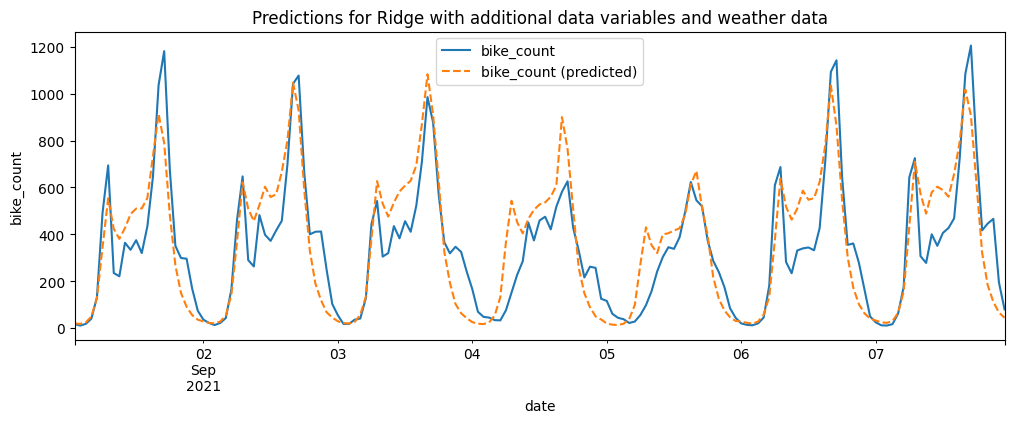

In [28]:
problem.week_plot(
    X_test, y_pred_test, y_test, "Ridge with additional data variables and weather data"
)

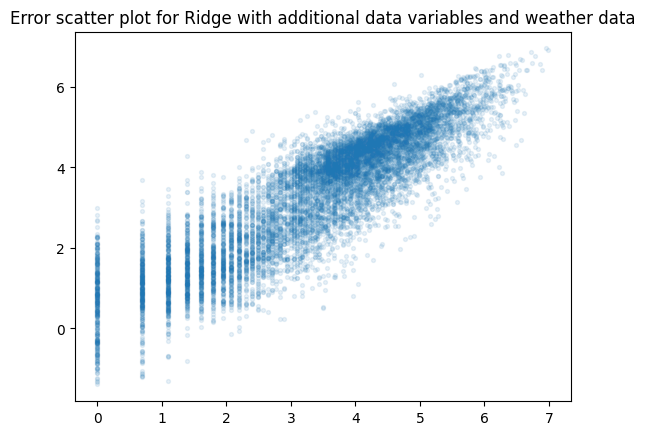

In [29]:
problem.error_plot(
    y_pred_test, y_test, "Ridge with additional data variables and weather data"
)

## Lasso

### Lasso including additional data variables and weather data

In [30]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(problem._additional_date_variables)
add_date_cols = ["season"]

num_cols = ["temp", "dwpt", "rhum", "prcp", "wspd", "pres"]

categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols + add_date_cols),
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
)

regressor = Lasso()

pipe = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor,
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7ff0f1ecc700>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7ff0f1ecc5e0>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7ff0f1ecc670>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour',
                                                   'season']),
                                                 ('num', StandardScaler(),
                                                  ['temp', 'dwpt', 'rhum',
                                                   'prcp', 'wspd', 'pres']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wdir'])])),
                ('lasso', Lasso())])

In [31]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=1.68
Test set, RMSE=1.49


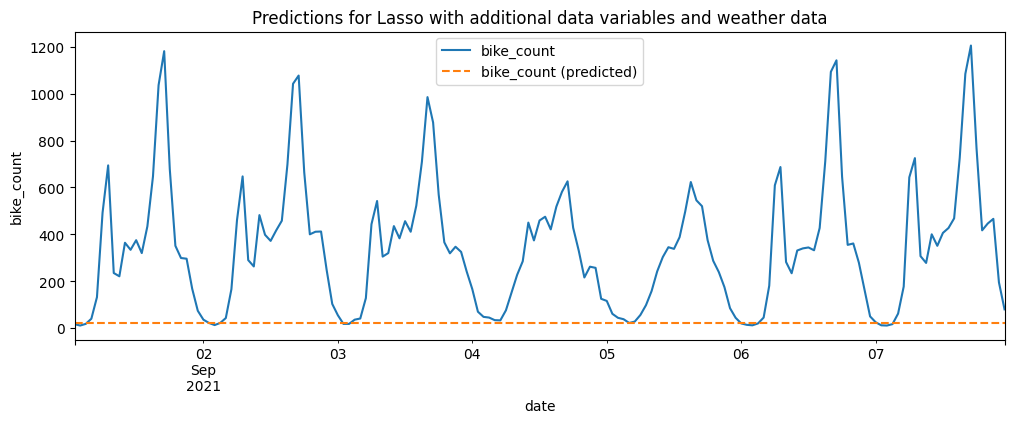

In [32]:
problem.week_plot(
    X_test, y_pred_test, y_test, "Lasso with additional data variables and weather data"
)

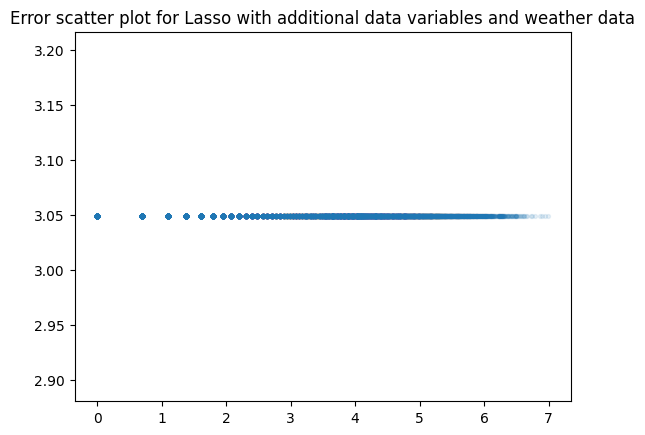

In [33]:
problem.error_plot(
    y_pred_test, y_test, "Lasso with additional data variables and weather data"
)

### Tuned Lasso including additional data variables and weather data

In [40]:
cv_results = pd.read_csv(
    os.path.join(path_tuning, "20221119_1318_tuning_lasso_cv_results.csv")
)
tuning_lasso = load(
    os.path.join(path_tuning, "20221119_1318_tuning_lasso_best_estimator.pkl")
)

In [41]:
tuning_lasso

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7ff0f1ecc700>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7ff0f1ecc5e0>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7ff0f1ecc670>,
                                     kw_args={'drop_date': True})),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour',
                                                   'season']),
                                                 ('num', StandardScaler(),
                                                  ['temp', 'dwpt', 'rhum',
                                                   'prcp', 'wspd', 'pres']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wdir'])])),
                ('lasso', Lasso(alpha=0.002))])

In [42]:
y_pred_train = tuning_lasso.predict(X_train)
y_pred_test = tuning_lasso.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.80
Test set, RMSE=0.71


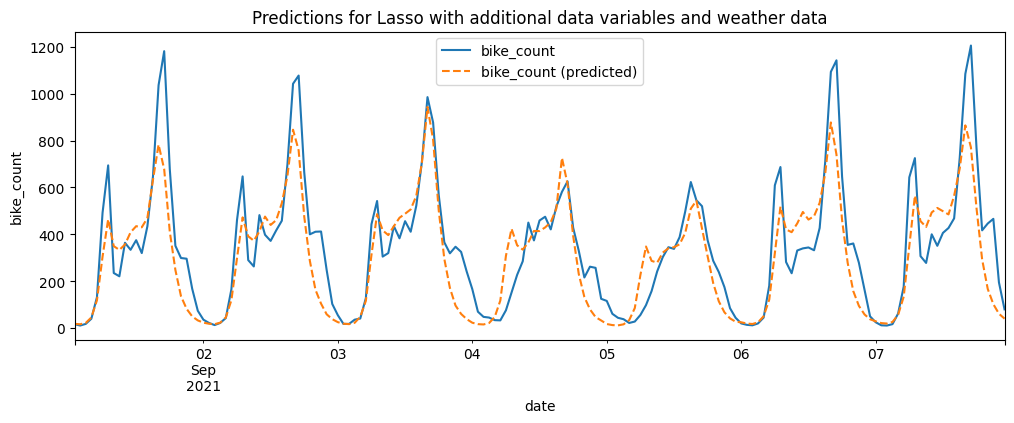

In [43]:
problem.week_plot(
    X_test, y_pred_test, y_test, "Lasso with additional data variables and weather data"
)

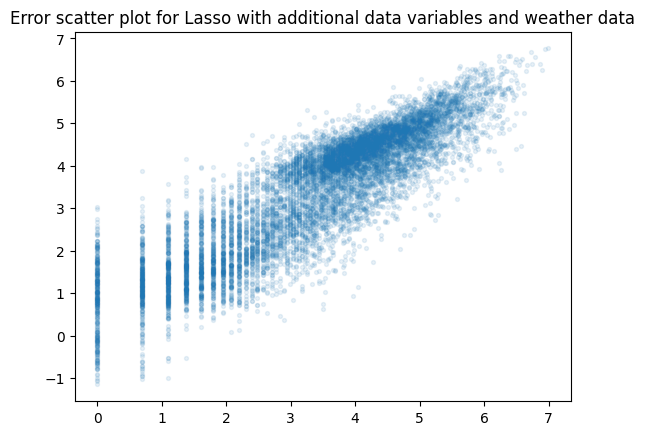

In [44]:
problem.error_plot(
    y_pred_test, y_test, "Lasso with additional data variables and weather data"
)